In [81]:
import re
import copy
import uuid
from unicodedata import normalize
from string import punctuation
import warnings
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.corpus import machado, mac_morpho, floresta
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [82]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [remover_acentos(palavra.lemma_)]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ["um", "uma", "não", "mais", "muito"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7) # , (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

In [83]:
df_data = pd.read_csv("gnews.csv", sep=';', names=["title", "description"])
df_data.dropna(inplace=True)

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(HTML(df_data.iloc[index].sort_values(by=["title"]).to_html(index=False)))

title,description
#VazaJato: Moro não seguiu padrão da Lava Jato ao divulgar conversas de Lula,"Mensagens obtidas pelo The Intercept Brasil e divulgadas neste domingo (24) pelo jornal Folha de S.Paulo mostram que o ministro da Justiça e então juiz federal, Sergio Moro, não seguiu o padrão da operação Lava Jato ao retirar o sigilo das investigações"
BE pressiona Governo com redução do IVA na eletricidade. PSD também quer. Mas descarta nova coligação negativa,"O Bloco de Esquerda vai mesmo insistir com a proposta de redução do IVA na eletricidade e mesmo que o governo não ceda, a questão pode vir a colocar-se no plano parlamentar. Tanto o Bloco de Esquerda como o PSD inscreveram no programa eleitoral para as legisl"
Bitcoin em foco,"O Bitcoin se encontra numa faixa de não compra ou venda. Convém esperar os próximos movimentos (Imagem: Pixabay)Há apenas algumas semanas, o preço do Bitcoin passou por um aumento que não víamos desde 2011 aumentou mais de 40% em um dia, chegando a US$ 10"
Crime na cidade da Praia: Um homem morto a tiro e um ferido perto da capital cabo-verdiana,"Um homem com cerca de 50 anos foi este sábado morto a tiro e outro ficou ferido, no município cabo-verdiano de São Domingos, a cerca de 10 quilómetros da cidade da Praia, segundo informação da Polícia Judiciária cabo-verdiana.Em comunicado, aquela força pol"
Dica: Configurar as novas opções das permissões de localização do Android 10,"O Android 10 trouxe várias novidades, mas ficou-se principalmente na segurança dos utilizadores. Para isso tem novas permissões e novas opções que podem ser decerto usadas pelos utilizadores.Uma delas não é de imediato visível, mas pode ser explorada e apro"
"Em súmula, árbitro diz que 'não observou injúria racial' contra goleiro do Flamengo","O árbitro Thiago Dias Paes Raimundo relatou na súmula não ter observado injúrias raciais contra o goleiro Hugo Souza, do Flamengo, já na parte final da decisão do Campeonato Carioca sub-20, na última quarta-feira, em São Januário. Nos acréscimos da partida, o"
Evidência,"Racismo estruturalO racismo existe e é inegável. Segundo o dr. Osvaldo Mariotto Cerezer, docente na Unemat, uma das formas de enfrentar este problema social é reconhecer que a história afro-brasileira é parte da história do Brasil. Ele acredita que, a parti"
Fantasias originais da série de TV de Batman e Robin serão leiloadas,"Um par de figurinos de Batman e Robin, descritos como as únicas fantasias completas usadas no programa de televisão dos anos 1060, está sendo leiloado em Los Angeles, e o proprietário está determinado em fazer com que seus heróis de quadrinhos de infância fiq"
Os melhores lançamentos de filmes e séries para assistir online (15/11 a 22/11),"O fim de semana chegou e como estamos quase no fim do mês de novembro, é possível que a grana esteja curta. Sem poder esbanjar nos rolês, muita gente opta por ficar em casa para assistir a um bom filme ou série. Se essa é a sua realidade, calma, não se desesp"
Sem-abrigo: Lisboa quer que todos tenham um teto em dois anos,"A Câmara de Lisboa está a preparar propostas individuais para, nos próximos dois anos, conseguir realojar os 361 sem-abrigo que vivem nas ruas da cidade, disse o vereador dos Direitos Sociais, Manuel Grilo.O presidente da República pediu uma solução naciona"


In [84]:
def doc2token(doc):
    if isinstance(doc, list):
        doc = " ".join(doc)
    return TaggedDocument(tokenizer(doc), [str(uuid.uuid4())])

print("Tokenization...")
docs = set(df_data["description"])
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    documents_d2c = list(exc.map(doc2token, docs, chunksize=100))
print("Qtd documentos treino: ", len(documents_d2c))
print("Finished...")

Tokenization...
Qtd documentos treino:  3099
Finished...


In [85]:
documents_d2c[:10]

[TaggedDocument(words=['rir', 'terceiro', 'turma', 'superior', 'tribunal', 'justicar', 'stj', 'decidir', 'caber', 'plano', 'saudar', 'custear', 'despesa', 'diario', 'refeicao', 'acompanhante', 'paciente', 'idoso', 'internar', 'decisao', 'reformar', 'acordao', 'tribunal', 'just'], tags=['329a99ec-a094-410f-83da-f6c746bb9f8d']),
 TaggedDocument(words=['huawei', 'ir', 'revelar', 'oficialmente', 'tablet', 'matepad', 'pro', 'novembro', 'nao', 'impedir', 'apanhar', 'atraves', 'imagem', 'video', 'oficiais.o', 'matepad', 'pro', 'adoptar', 'um', 'design', 'identico', 'ipad', 'pro', 'apple', 'basicamente', 'consistir', 'um', 'ec'], tags=['6b885792-e8bf-440f-bd6e-e42aa4bb6fed']),
 TaggedDocument(words=['utilizacao', 'energia', 'atomico', 'fim', 'militar', 'hoje', 'mais', 'um', 'crime', 'nao', 'somente', 'contra', 'homem', 'dignidade', 'contra', 'todo', 'possibilidade', 'futurar', 'casar', 'comum', 'afirmar', 'papar', 'mensagem', 'pronunciar', 'memorial', 'paz', 'na'], tags=['8ef9ef47-59f4-4824-a7

In [87]:
print("building vocab...")
vocab = copy.deepcopy(documents_d2c)
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    print("Adding machado...")
    vocab += list(exc.map(doc2token, utils.shuffle(machado.sents(), n_samples=100), chunksize=100))
    print("Adding mac_morpho...")
    vocab += list(exc.map(doc2token, utils.shuffle(mac_morpho.sents(), n_samples=100), chunksize=100))
    print("Adding floresta...")
    vocab += list(exc.map(doc2token, utils.shuffle(floresta.sents(), n_samples=100), chunksize=100))
print("finish...")

building vocab...
Adding machado...
Adding mac_morpho...
Adding floresta...
finish...


In [88]:
len(vocab)

3399

In [89]:
dim = 1500
epochs = 20
M = 15000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 1500
Epochs       : 20
Infer Epochs : 15000


In [90]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=cpu_count(), 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(vocab)
print("Training...")
d2v.train(
    documents_d2c,
    # total_examples=d2v.corpus_count,
    total_examples=len(documents_d2c),
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


In [91]:
X = d2v.docvecs.vectors_docs
print(X.shape)

(3399, 1500)


In [93]:
def get_doc_vector(doc):
    return d2v.docvecs[doc.tags[0]]

X = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    X = list(exc.map(get_doc_vector, documents_d2c, chunksize=100))
X = np.asarray(X)
print(X.shape)

(3099, 1500)


In [94]:
cosine_distance_matrix = 1 - cosine_similarity(X)
print(cosine_distance_matrix.shape)

(3099, 3099)


In [ ]:
kmin = 2
kmax = int(np.ceil((X.shape[0] * 0.1)))
kmax = 50 if kmax > 50 else kmax

print("Running Elbow...")
elbow_error = []
elbow_amount_clusters = 2
for _ in range(5):
    elbow_instance = elbow(cosine_distance_matrix, kmin, kmax)
    elbow_instance.process()
    amc = elbow_instance.get_amount()
    if amc > elbow_amount_clusters:
        elbow_amount_clusters = amc
        elbow_error = elbow_instance.get_wce()

print("Running Silhouette...")
silhouette_amount_clusters = 0
silhouette_instance = silhouette_ksearch(cosine_distance_matrix, kmin, kmax, algorithm=silhouette_ksearch_type.KMEANS)
silhouette_instance.process()
silhouette_amount_clusters = silhouette_instance.get_amount()
scores = np.asarray(silhouette_instance.get_scores())
scores[np.isnan(scores)] = -1

print("N. Elbow      Cluster : ", elbow_amount_clusters)
print("N. Silhouette Cluster : ", silhouette_amount_clusters)
qtd_cluster = elbow_amount_clusters if elbow_amount_clusters > silhouette_amount_clusters else silhouette_amount_clusters

Running Elbow...
Running Silhouette...


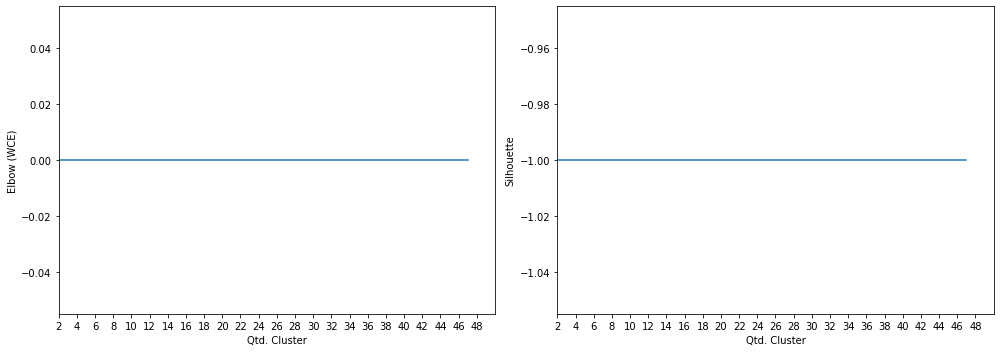

In [69]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(elbow_error)
plt.xticks(range(kmin, kmax, 2))
ax.set_xlim(kmin, kmax)
plt.xlabel("Qtd. Cluster")
plt.ylabel("Elbow (WCE)")
ax = plt.subplot(1, 2, 2)
plt.plot(scores)
plt.xticks(range(kmin, kmax, 2))
ax.set_xlim(kmin, kmax)
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [13]:
kclusterer = KMeansClusterer(
    qtd_cluster,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [14]:
docs = np.asarray(df_data["title"])

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["title", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])

print("Documentos por cluster:")
T = df.to_numpy()
index = np.random.choice(T.shape[0], 30, replace=False)
display(HTML(df.loc[index].sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Documentos por cluster:


title,cluster
"Russell: ""Kubica é incrivelmente experiente e fará falta na Williams""",0
As piscinas naturais que podem ter chave para 'cura' do planeta com biodiversidade 'pré-histórica',0
Ingram Micro anuncia uma nova e promissora parceria com a CUSTOM,0
Campinas imuniza 370 adultos de até 29 anos contra sarampo em 3 dias de campanha,0
"Morreu o rabino Henry Sobel, ativista contra a ditadura militar brasileira",2
Defesa e Educação recebem maior parte dos R$ 14 bi liberados para gastos no orçamento,3
"Jorge Jesus confiante em vencer prova ""que tem o mesmo prestígio da ‘Champions’""",4
Candidato liga para melhor colocado em concurso e diz que teste foi cancelado,4
"Criptomoedas são ""péssima ideia"" e interferem com a política monetária",4
"Após semana conturbada, Santos joga para garantir vaga direta na Libertadores",4


--------------------
Documentos por cluster:


C0,218
C1,103
C2,165
C3,199
C4,221
C5,286
C6,146
C7,173
C8,170
C9,130
C10,190
